# Decoding a TFRecord file from the ImageNet dataset

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.config.experimental.set_visible_devices([], 'GPU') # force CPU usage
tf.version.VERSION

'2.5.0'

In [2]:
list_of_files = sorted(glob.glob('/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/*'))
list_of_files[:4], len(list_of_files)

(['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00000-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00001-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00002-of-00128',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00003-of-00128'],
 128)

In [3]:
# TFRecordDataset also accepts glob patterns directly and S3/GCP filesystem
dataset = tf.data.TFRecordDataset(list_of_files)
sample = next(iter( dataset ))

tf.train.Example.FromString(sample.numpy())

features {
  feature {
    key: "image/channels"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "image/class/label"
    value {
      int64_list {
        value: 66
      }
    }
  }
  feature {
    key: "image/class/synset"
    value {
      bytes_list {
        value: "n01751748"
      }
    }
  }
  feature {
    key: "image/colorspace"
    value {
      bytes_list {
        value: "RGB"
      }
    }
  }
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000`\000`\000\000\377\355\000\034Photoshop 3.0\0008BIM\004\004\000\000\000\000\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\002\002\003\002\002\002\002\002\004\003\003\002\003\005\004\005\005\005\004\004\004\005\006\007\006\005\005\007\006\004\004\006\t\006\007\010\010\010\010\010\005\006\t\n\t\010\n\007\010\010\010\377\333\000C\001\001\001\001\002\002\002\004\002\002\004\010\005\004\0

In [4]:
def decode(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    return image, label


dataset = tf.data.TFRecordDataset(list_of_files)
dataset = dataset.map(decode)

Please check the following link for an example on how to write TF Records:
https://github.com/tensorflow/tpu/blob/master/tools/datasets/imagenet_to_gcs.py#L256-L281

Note: it can useful to add the number of images in each TF record on the filename itself

Image shape: (375, 500, 3) Label: 65


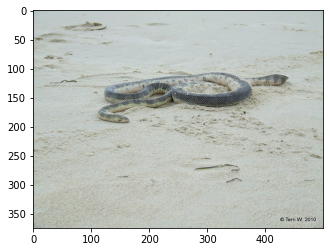

In [5]:
image, label = next(iter( dataset ))
print('Image shape:', image.shape, 'Label:', label.numpy())

plt.imshow(image)
plt.show()

In [6]:
dataset = dataset.batch(8)

images, labels = next(iter( dataset ))
print('Image shape:', images.shape, 'Labels:', labels.numpy())

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [333,500,3], [batch]: [375,500,3] [Op:IteratorGetNext]

In [7]:
image_shape = (224, 224)

def resize_img(image, label):
    return tf.image.resize_with_pad(image, *image_shape), label


dataset = tf.data.TFRecordDataset(list_of_files)
dataset = dataset.map(decode)
dataset = dataset.map(resize_img)
dataset = dataset.batch(8)


images, labels = next(iter( dataset ))
print('Image shape:', images.shape, 'Labels:', labels.numpy())

Image shape: (8, 224, 224, 3) Labels: [ 65 970 230 809 516  57 334 415]


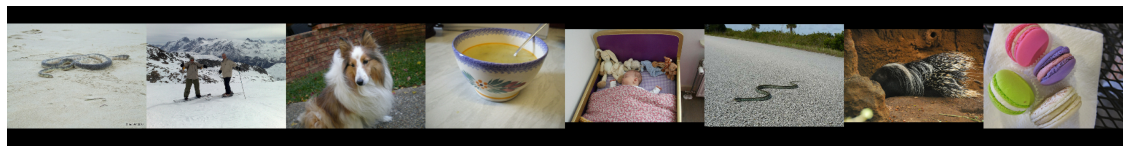

In [8]:
concat = np.concatenate(images.numpy(), 1)

fig, ax = plt.subplots(figsize=(20, 3))
ax.imshow(concat.astype(int))
plt.axis('off')
plt.show()